## Course Assignment Instructions
You should have Python (version 3.8 or later) and Jupyter Notebook installed to complete this assignment. You will write code in the empty cell/cells below the problem. While most of this will be a programming assignment, some questions will ask you to "write a few sentences" in markdown cells. 

Submission Instructions:

Create a labs directory in your personal class repository (e.g., located in your home directory)
Clone the class repository
Copy this Jupyter notebook file (.ipynb) into your repo/labs directory
Make your edits, commit changes, and push to your repository
All submissions must be pushed before the due date to avoid late penalties. 

Labs are graded out of a 100 pts. Each day late is -10. For a max penalty of -50 after 5 days. From there you may submit the lab anytime before the semester ends for a max score of 50.  

Lab 7 is due on 4/21/25 

## Polynomial Regression and Interaction Regression

We will work with the diamonds dataset again. Here we load up the dataset and convert all factors to nominal type:

In [68]:
import pandas as pd
import numpy as np
from plotnine.data import diamonds

# Load the diamonds dataset and create a copy
diamonds = diamonds.copy()

# Convert factors to nominal (unordered categorical) type
diamonds['cut'] = pd.Categorical(diamonds['cut'], ordered=False)
diamonds['color'] = pd.Categorical(diamonds['color'], ordered=False)
diamonds['clarity'] = pd.Categorical(diamonds['clarity'], ordered=False)

# Print summary statistics similar to skimr
print("Summary Statistics:")
print(diamonds.describe(include = "all"))

print()
# Calculate and print the number of missing values per column
missing_counts = diamonds.isnull().sum()
print("\nMissing Values:")
print(missing_counts)

Summary Statistics:
               carat    cut  color clarity         depth         table  \
count   53940.000000  53940  53940   53940  53940.000000  53940.000000   
unique           NaN      5      7       8           NaN           NaN   
top              NaN  Ideal      G     SI1           NaN           NaN   
freq             NaN  21551  11292   13065           NaN           NaN   
mean        0.797940    NaN    NaN     NaN     61.749405     57.457184   
std         0.474011    NaN    NaN     NaN      1.432621      2.234491   
min         0.200000    NaN    NaN     NaN     43.000000     43.000000   
25%         0.400000    NaN    NaN     NaN     61.000000     56.000000   
50%         0.700000    NaN    NaN     NaN     61.800000     57.000000   
75%         1.040000    NaN    NaN     NaN     62.500000     59.000000   
max         5.010000    NaN    NaN     NaN     79.000000     95.000000   

               price             x             y             z  
count   53940.000000  5394

Given the information above, what are the number of columns in the raw X matrix?

10

Verify this using code:

In [69]:
# Compute the number of columns
diamonds.shape[1]

10

Would it make sense to use polynomial expansions for the variables cut, color and clarity? Why or why not?

No, it would not make sense to use polynomial expansions for cut, color, and clarity because they are categorical variables, not numerical.

Would it make sense to use log transformations for the variables cut, color and clarity? Why or why not?

no because cut, color, and clarity are categorical, not numerical and Log transformations are meant for skewed numeric data

In order to ensure there is no time trend in the data, randomize the order of the diamond observations in D:.

In [70]:
# Randomize the order of the diamond observations
diamonds_shuffled = diamonds.sample(frac = 1, random_state = 123).reset_index(drop = True)


# View the first few rows of the shuffled dataset
diamonds_shuffled.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.31,Premium,G,VS1,63.0,57.0,802,4.32,4.28,2.71
1,0.46,Ideal,E,SI2,61.3,55.0,935,4.98,5.00,3.06
2,1.21,Very Good,H,SI1,62.4,58.0,5826,6.83,6.79,4.25
3,0.41,Ideal,E,VS2,62.1,57.0,935,4.74,4.79,2.96
4,0.90,Ideal,J,VS2,62.8,55.0,2817,6.20,6.16,3.88


Let's also concentrate only on diamonds with <= 2 carats to avoid the issue we saw with the maximum. So subset the dataset. Create a variable n equal to the number of remaining rows as this will be useful for later. Then plot it.

53940
Number of remaining rows: 52051


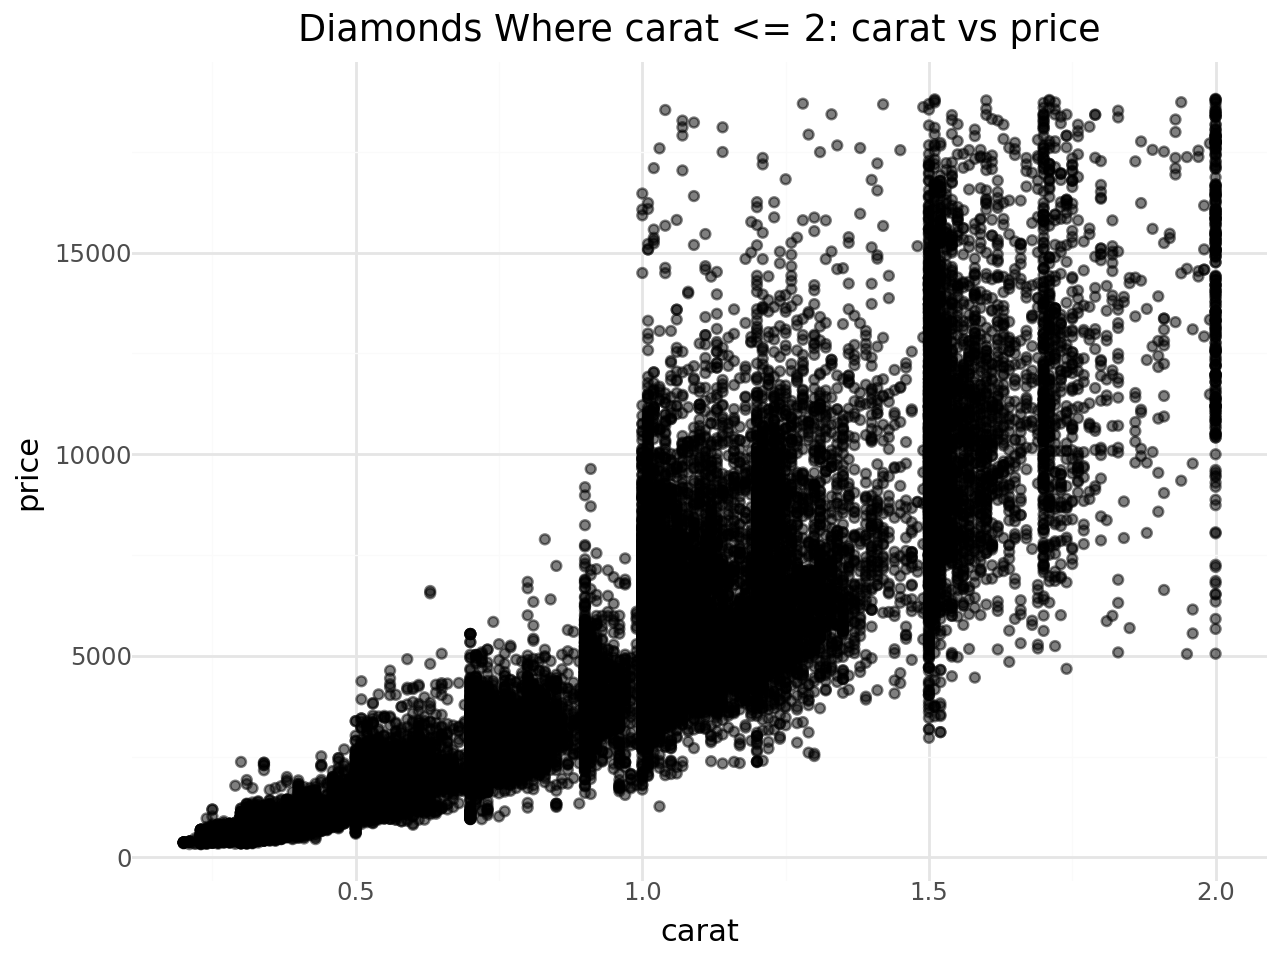

In [71]:
from plotnine import ggplot, aes, geom_point, labs, theme_minimal

# Subset to diamonds with <= 2 carats

diamonds_subset = diamonds_shuffled[diamonds_shuffled['carat']<=2]

# Create a variable n equal to the number of rows in the subset
print(diamonds_shuffled.shape[0]) # number of rows before exluding carat size > 2
n = diamonds_subset.shape[0]
print("Number of remaining rows:", n)

# Plot: For example, plot carat vs price
p = (ggplot(diamonds_subset, aes(x='carat', y='price')) +
     geom_point(alpha = .5) +
     labs(title = "Diamonds Where carat <= 2: carat vs price") +
     theme_minimal())

p

Create a linear model of price ~ carat and gauge its in-sample performance using s_e.

In [72]:
import statsmodels.api as sm

# Define the independent variable (carat) and the dependent variable (price)
X = diamonds_subset['carat']
y = diamonds_subset['price']

# Add a constant term to the independent variable for the intercept
X = sm.add_constant(X)


# Fit the linear model using OLS (Ordinary Least Squares)
model = sm.OLS(y, X).fit()

# Extract the residual standard error (s_e) 
# In statsmodels, the scale attribute gives the variance of the residuals, so we take the square root.
s_e = np.sqrt(model.scale)

# Print the residual standard error
print("Residual standard error (s_e):", s_e)

Residual standard error (s_e): 1451.9268767656401


Create a model of price ~ clarity and gauge its in-sample performance

In [78]:
# Create an explicit copy of diamonds_subset if not already done
diamonds_clarity_modification = diamonds_subset.copy()

# Convert the 'clarity' categorical variable into numeric codes
# This creates a new column 'clarity_numeric' where each level is mapped to an integer.

diamonds_clarity_modification['clarity_numeric'] = diamonds_clarity_modification['clarity'].astype('category').cat.codes
# Prepare the independent variable (include a constant)
X = sm.add_constant(diamonds_clarity_modification['clarity_numeric'].astype(float))

# Dependent variable
y = diamonds_clarity_modification['price']

# Fit the linear model using OLS
model2 = sm.OLS(y, X).fit()

# Extract the residual standard error (s_e)
s_e = np.sqrt(model2.scale)

# Print the residual standard error
print("Residual standard error (s_e):", s_e )

Residual standard error (s_e): 3403.8252104875914


Why is the model price ~ carat substantially more accurate than price ~ clarity?

because the model price~carat has a lower residual standard error

Create a new transformed feature ln_carat and plot it vs price.

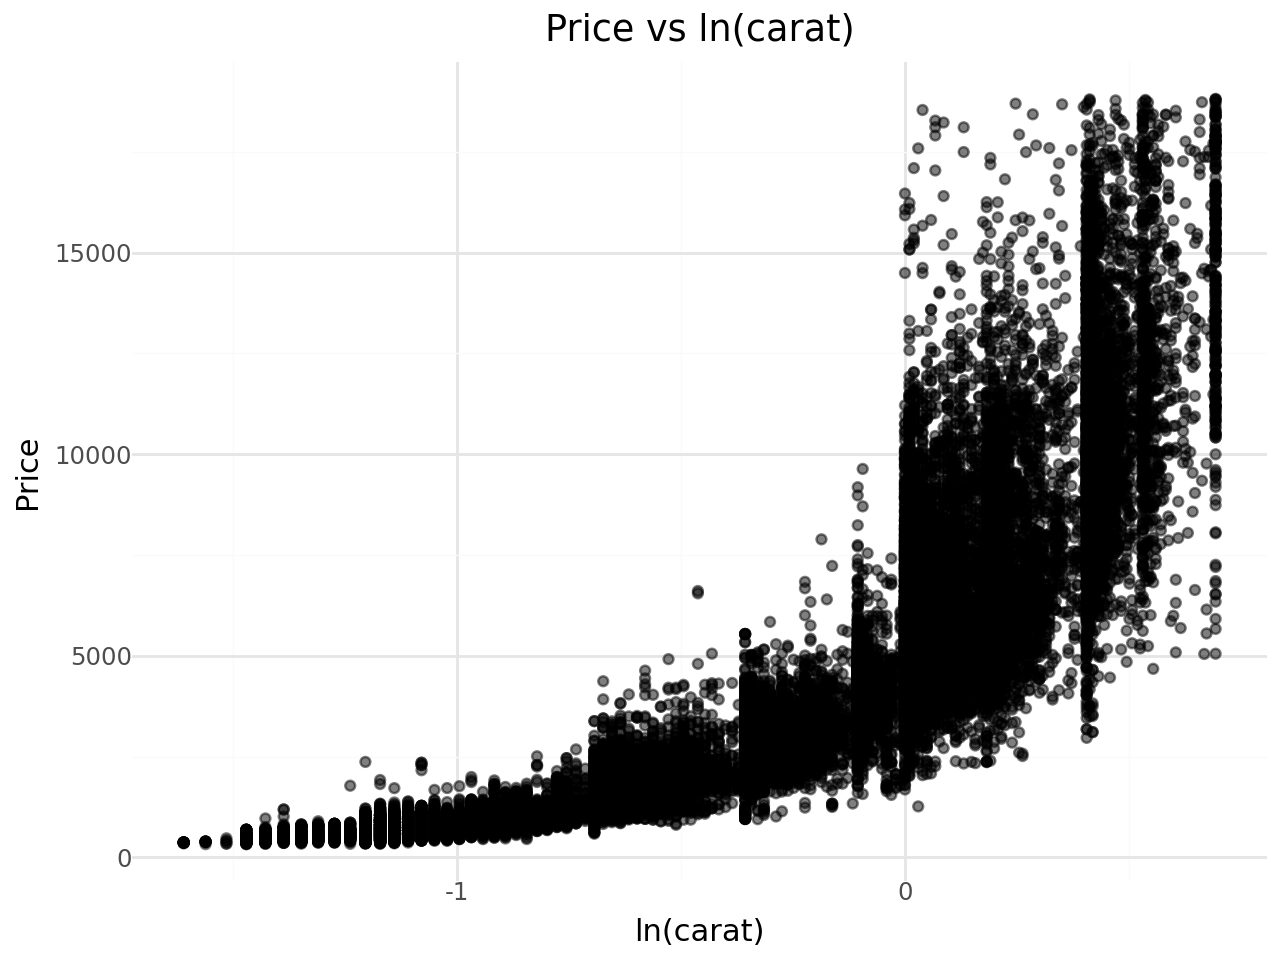

In [84]:
import numpy as np
from plotnine import ggplot, aes, geom_point, labs, theme_minimal

# Create an explicit copy of diamonds_subset
diamonds_ln_subset = diamonds_subset.copy()

# Create a new column with the natural logarithm of carat
diamonds_ln_subset['ln_carat'] = np.log(diamonds_ln_subset['carat'])

# Plot ln_carat vs price using plotnine
p = (ggplot(diamonds_ln_subset, aes(x='ln_carat', y='price')) +
     geom_point(alpha=0.5) +
     labs(title="Price vs ln(carat)", x='ln(carat)', y='Price') +
     theme_minimal())

p

Would price ~ ln_carat be a better fitting model than price ~ carat? Why or why not?

we check for to check for linearity and homoscedasticity so price vs. ln(carat) is a better fit because more linearity and tends to have increasing spread (variance) in price as carat increases — heteroscedasticity.

Verify this by comparing R^2 and RMSE of the two models:

In [85]:
#Model 1 price ~ carat
X = diamonds_subset['carat']
y = diamonds_subset['price']

# Add a constant term to the independent variable for the intercept
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
r2_model = model.rsquared
rmse_model = np.sqrt(np.mean(model.resid**2))

#Model 2 price ~ ln_carat
X2 = sm.add_constant(diamonds_ln_subset['ln_carat'])
model2 = sm.OLS(y, X2).fit()
r2_model2 = model2.rsquared
rmse_model2 = np.sqrt(np.mean(model2.resid**2))

# Print R² and RMSE for both models
print("Model price ~ carat:")
print("  R² =", r2_model)
print("  RMSE =", rmse_model, "\n")

print("Model price ~ ln(carat):")
print("  R² =", r2_model2)
print("  RMSE =", rmse_model2)

Model price ~ carat:
  R² = 0.8192395330750623
  RMSE = 1451.8989821848602 

Model price ~ ln(carat):
  R² = 0.7122155914252803
  RMSE = 1831.9697752496327


Create a new transformed feature ln_price and plot its estimated density:

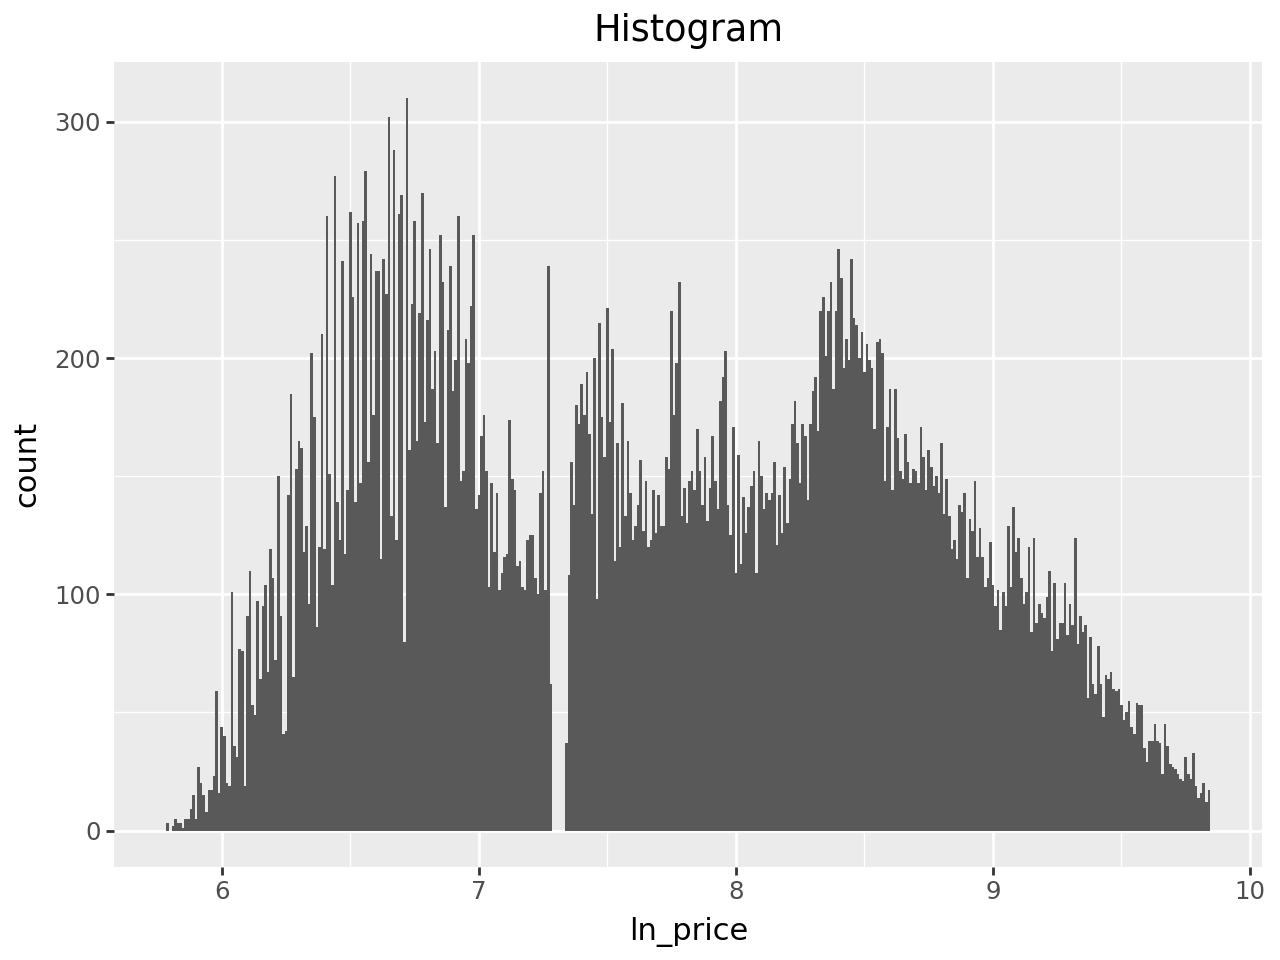

In [88]:
from plotnine import ggplot, aes, geom_histogram, labs
import numpy as np

# Create the ln_price feature by taking the natural logarithm of price
diamonds_ln_subset['ln_price'] = np.log(diamonds_ln_subset['price'])

# Plot the histogram of ln_price with a binwidth of 0.01 using plotnine
p = (ggplot(diamonds_ln_subset) +
     geom_histogram(aes(x='ln_price'), binwidth=0.01) +
     labs(title="Histogram", x='ln_price', y='count'))

p


Now plot it vs carat.

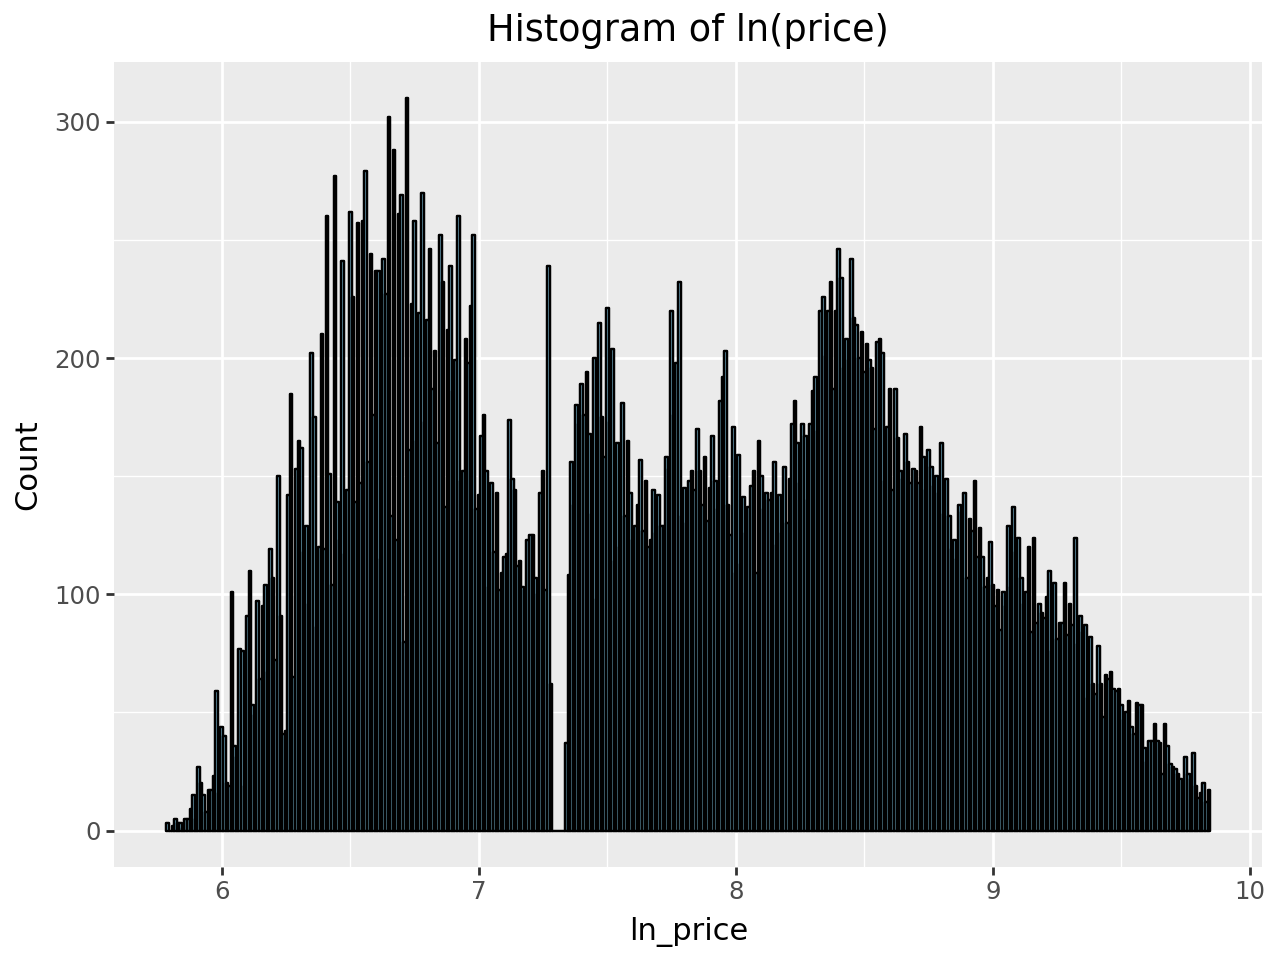

In [92]:
from plotnine import ggplot, aes, geom_histogram, labs
import numpy as np

# Make sure the log column exists
diamonds_ln_subset['ln_price'] = np.log(diamonds_ln_subset['price'])

# Histogram of ln_price
p = (ggplot(diamonds_ln_subset, aes(x='ln_price')) +
     geom_histogram(binwidth=0.01, fill="skyblue", color="black") +
     labs(title="Histogram of ln(price)", x='ln_price', y='Count'))

p



Would ln_price ~ carat be a better fitting model than price ~ carat? Why or why not?

histogram tells us how skewed or normal a variable is, the ln transformation usually normalizes the distribution, making it more symmetric and bell-shaped so ln is better/ it reduces skewness and extreme values

Verify this by computing s_e of this new model. Make sure these metrics can be compared apples-to-apples with the previous.

In [94]:
# Fit the linear model on the log scale
X = sm.add_constant(diamonds_ln_subset['carat'])
y = diamonds_ln_subset['ln_price']

# Metrics on the log scale
model_ln = sm.OLS(y, X).fit()
r2_log = model_ln.rsquared
rmse_log = np.sqrt(np.mean(model_ln.resid**2))

# Back-transform predictions to original price scale
pred_ln_price = model_ln.predict(X)
pred_price = np.exp(pred_ln_price)

# Compute RMSE on the original price scale
resid_price = diamonds_subset['price'] - pred_price
rmse_orig = np.sqrt(np.mean(resid_price**2))

# Compute R² on the original price scale
price = diamonds_subset['price']  # Corrected this line
tss = np.sum((price - np.mean(price))**2)  # Total Sum of Squares
rss = np.sum((price - pred_price)**2)       # Residual Sum of Squares
r2_orig = 1 - (rss/tss)

# Print the results
print("Model ln(price) ~ carat (Log Scale):")
print("  R² (log scale)  =", r2_log)
print("  RMSE (log scale) =", rmse_log)
print("\nModel ln(price) ~ carat (Original Price Scale):")
print("  R² (original scale) =", r2_orig)
print("  RMSE (original scale) =", rmse_orig)


Model ln(price) ~ carat (Log Scale):
  R² (log scale)  = 0.8812677436334697
  RMSE (log scale) = 0.3345372478284673

Model ln(price) ~ carat (Original Price Scale):
  R² (original scale) = 0.36288653122121406
  RMSE (original scale) = 2725.7942225986367


We just compared in-sample statistics to draw a conclusion on which model has better performance. But in-sample statistics can lie! Why is what we did valid?

By looking at the r2 and RMSE for both models, seeing how well the model explains the variance in the data and how well it predicts on the data it was trained on, useful for understanding the goodness of fit for the specific dataset. However, in-sample statistics can lie because they don't account for how the model might perform on unseen data = overfitting!

Plot ln_price vs ln_carat.

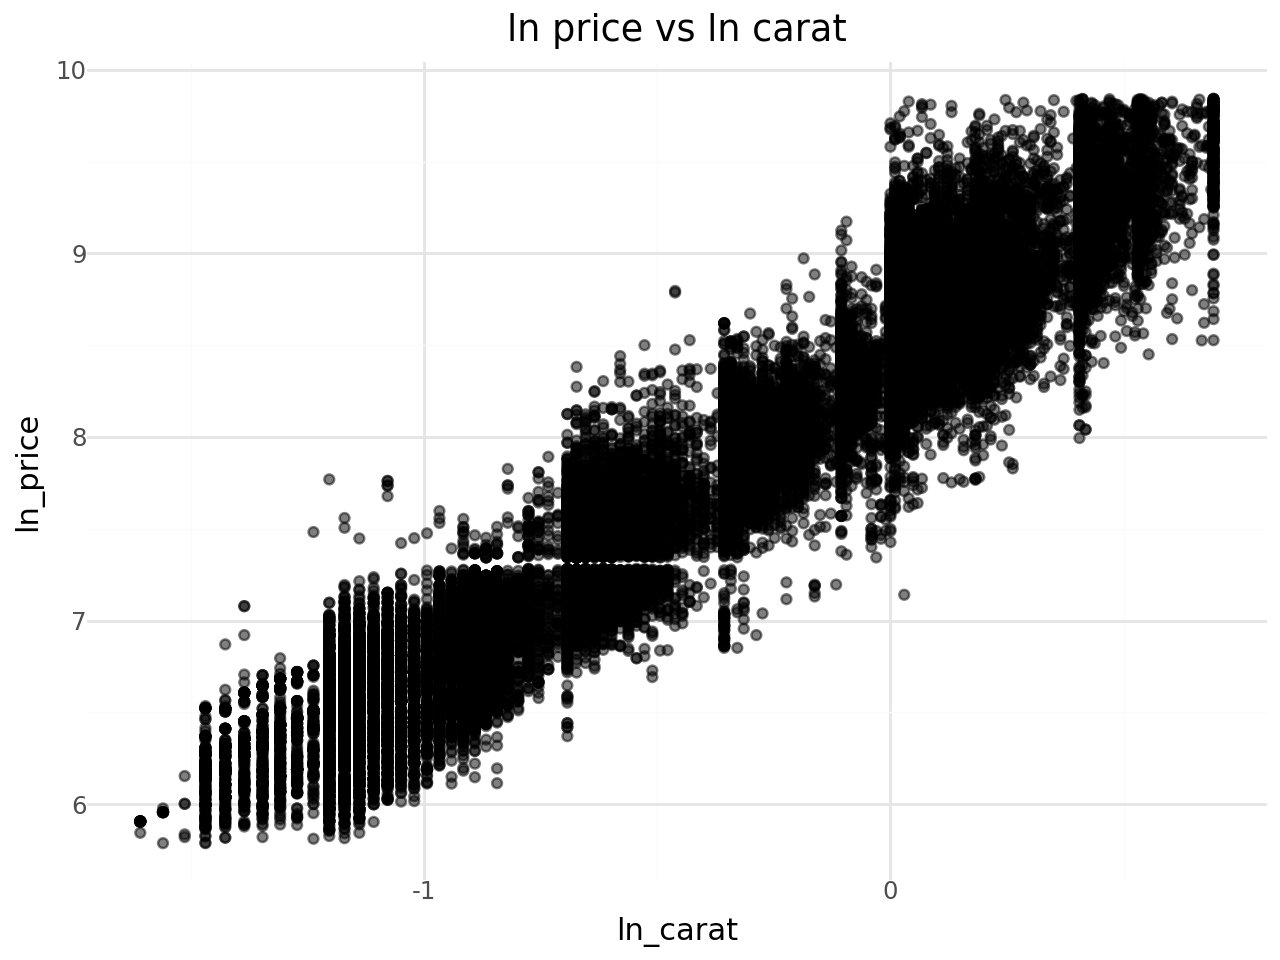

In [95]:
# Create transformed features

diamonds_ln_subset['ln_price'] = np.log(diamonds_ln_subset['price'])
diamonds_ln_subset['ln_carat'] = np.log(diamonds_ln_subset['carat'])
# Plot ln_price vs ln_carat using plotnine


# Plot: For example, plot carat vs price
p = (ggplot(diamonds_ln_subset, aes(x='ln_carat', y='ln_price')) +
     geom_point(alpha = .5) +
     labs(title = "ln price vs ln carat") +
     theme_minimal())

p

Would ln_price ~ ln_carat be the best fitting model than the previous three we considered? Why or why not?

yes its an even better linear model 

Verify this by computing s_e of this new model. Make sure these metrics can be compared apples-to-apples with the previous.

In [96]:
# Fit the model ln(price) ~ ln(carat)

X = sm.add_constant(diamonds_ln_subset['ln_carat'])
y = diamonds_ln_subset['ln_price']
model_ln_ln = sm.OLS(y, X).fit()

# Metrics on the log scale
# Residual standard error (s_e) on the log scale
# model_ln_ln.scale is the variance of the residuals, so take sqrt
s_e_log = np.sqrt(model_ln_ln.scale)

# R^2 on the log scale
r2_log = model_ln_ln.rsquared


# B) Back-transform to price scale
pred_ln_price = model_ln_ln.predict(X)     # Predicted ln(price)
pred_price = np.exp(pred_ln_price)          # Predicted price

# Residuals on the original price scale
resids_price = diamonds_subset['price'] - pred_price

# Residual standard error (RMSE) on the original scale
s_e_price = np.sqrt(np.mean(resids_price**2))

# R^2 on the original scale
price_actual = diamonds_subset['price']
tss = np.sum((price_actual - price_actual.mean())**2)
rss = np.sum(resids_price**2)
r2_price = 1 - rss/tss

# Print results
print("Model ln(price) ~ ln(carat):")
print(" -- On the log scale:")
print("    s_e (log scale) =", s_e_log)
print("    R^2 (log scale) =", r2_log, "\n")
print(" -- On the original scale:")
print("    s_e (price scale) =", s_e_price)
print("    R^2 (price scale) =", r2_price)

Model ln(price) ~ ln(carat):
 -- On the log scale:
    s_e (log scale) = 0.2613383067685494
    R^2 (log scale) = 0.9275448566575142 

 -- On the original scale:
    s_e (price scale) = 1396.6434892034092
    R^2 (price scale) = 0.832736270844848


Compute b, the OLS slope coefficients for this new model of ln_price ~ ln_carat.

In [97]:
# Extract the slope coefficient (b) for ln_carat
b = model_ln_ln.params
b

const       8.462579
ln_carat    1.696590
dtype: float64

Interpret b_1, the estimated slope of ln_carat.

b1 = 1.6965... slope of 1.6966 means that for each 1% increase in carat size, the price of the diamond increases by approximately 1.6966% on the log scale

Interpret b_0, the estimated intercept.

b0 = 8.462... the log of the price for a diamond with 1 carat is 8.4626

Create other features ln_x, ln_y, ln_z, ln_depth, ln_table.

In [98]:
# Create new log-transformed features
epsilon = 1e-6

diamonds_ln_subset['ln_x'] = np.log(diamonds_ln_subset['x'] + epsilon)
diamonds_ln_subset['ln_y'] = np.log(diamonds_ln_subset['y'] + epsilon)
diamonds_ln_subset['ln_z'] = np.log(diamonds_ln_subset['z'] + epsilon)
diamonds_ln_subset['ln_depth'] = np.log(diamonds_ln_subset['depth'] + epsilon)
diamonds_ln_subset['ln_table'] = np.log(diamonds_ln_subset['table'] + epsilon)

# Optionally, display the first few rows of the transformed dataset
print(diamonds_ln_subset.head())

   carat        cut color clarity  depth  table  price     x     y     z  \
0   0.31    Premium     G     VS1   63.0   57.0    802  4.32  4.28  2.71   
1   0.46      Ideal     E     SI2   61.3   55.0    935  4.98  5.00  3.06   
2   1.21  Very Good     H     SI1   62.4   58.0   5826  6.83  6.79  4.25   
3   0.41      Ideal     E     VS2   62.1   57.0    935  4.74  4.79  2.96   
4   0.90      Ideal     J     VS2   62.8   55.0   2817  6.20  6.16  3.88   

   ln_carat  ln_price      ln_x      ln_y      ln_z  ln_depth  ln_table  
0 -1.171183  6.687109  1.463256  1.453953  0.996949  4.143135  4.043051  
1 -0.776529  6.840547  1.605430  1.609438  1.118415  4.115780  4.007333  
2  0.190620  8.670086  1.921325  1.915451  1.446919  4.133565  4.060443  
3 -0.891598  6.840547  1.556037  1.566531  1.085190  4.128746  4.043051  
4 -0.105361  7.943428  1.824549  1.818077  1.355835  4.139955  4.007333  


From now on, we will be modeling ln_price (not raw price) as the prediction target. 

Create a model (B) of ln_price on ln_carat interacted with clarity and compare its performance with the model (A) ln_price ~ ln_carat.

In [99]:
import statsmodels.formula.api as smf


#this is an interaction
# Model A: ln_price ~ ln_carat
model_A = smf.ols('ln_price ~ ln_carat', data=diamonds_ln_subset).fit()
r2_A = model_A.rsquared
rmse_A = np.sqrt(np.mean(model_A.resid**2))


# Model B: ln_price ~ ln_carat * clarity
model_B = smf.ols('ln_price ~ ln_carat * C(clarity)', data=diamonds_ln_subset).fit()
r2_B = model_B.rsquared
rmse_B = np.sqrt(np.mean(model_B.resid**2))


# Print comparison
print("Model A: ln_price ~ ln_carat")
print("  R² =", r2_A)
print("  RMSE =", rmse_A)
print("")
print("Model B: ln_price ~ ln_carat * clarity")
print("  R² =", r2_B)
print("  RMSE =", rmse_B)

Model A: ln_price ~ ln_carat
  R² = 0.9275448566575142
  RMSE = 0.26133328590790844

Model B: ln_price ~ ln_carat * clarity
  R² = 0.9630831364903961
  RMSE = 0.1865402339481072


Which model does better? Why?

model b does better- improved performence lower rmse and higher r2 

Create a model of (C) ln_price on ln_carat interacted with every categorical feature (clarity, cut and color) and compare its performance with model (B)

In [100]:
# Model C: ln_price ~ ln_carat interacted with clarity, cut, and color
model_C = smf.ols('ln_price ~ ln_carat * C(clarity) + ln_carat * C(cut) + ln_carat * C(color)', data=diamonds_ln_subset).fit()
r2_C = model_C.rsquared
rmse_C = np.sqrt(np.mean(model_C.resid**2))

print("Model C (ln_price ~ ln_carat * C(clarity) + ln_carat * C(cut) + ln_carat * C(color)):")
print("  R² =", r2_C)
print("  RMSE =", rmse_C)

Model C (ln_price ~ ln_carat * C(clarity) + ln_carat * C(cut) + ln_carat * C(color)):
  R² = 0.9820592739553672
  RMSE = 0.1300409478785979


Which model does better? Why?

model c does better have lower rmse - lower error

Create a model (D) of ln_price on every continuous feature (logs of carat, x, y, z, depth, table) interacted with every categorical feature (clarity, cut and color) and compare its performance with model (C).

In [101]:
# Model D: ln_price ~ (ln_carat + ln_x + ln_y + ln_z + ln_depth + ln_table) interacted with (clarity + cut + color)
# We include all continuous logs in one group and interact with all three categorical features.
# In the formula, '+' combines terms and '*' expands to main effects and interactions.


print("Model D (ln_price ~ ):")
model_D = smf.ols('ln_price ~ (ln_carat + ln_x + ln_y + ln_z + ln_depth + ln_table) * (C(clarity) + C(cut) + C(color))', data=diamonds_ln_subset).fit()
r2_D = model_D.rsquared
rmse_D = np.sqrt(np.mean(model_D.resid**2))

print("Model D (ln_price ~ (all continuous logs) * (C(clarity) + C(cut) + C(color))):")
print("  R² =", r2_D)
print("  RMSE =", rmse_D)

Model D (ln_price ~ ):
Model D (ln_price ~ (all continuous logs) * (C(clarity) + C(cut) + C(color))):
  R² = 0.9828630904899284
  RMSE = 0.12709438703485498


Which model does better? Why?

D because lower standard error and higher r2

What is the p of this model D? Compute with code.

In [102]:
# Compute the number of parameters (p) in the model, including the intercept
p = len(model_D.params)
print("The number of parameters (p) in Model D is:", p)

The number of parameters (p) in Model D is: 126


Create model (E) which is the same as before except create include the raw features interacted with the categorical features and gauge the performance against (D).

In [103]:
# Model E: using raw continuous features
# ln_price ~ (carat + x + y + z + depth + table) * (C(clarity) + C(cut) + C(color))
model_E = smf.ols('ln_price ~ (carat + x + y + z + depth + table) * (C(clarity) + C(cut) + C(color))', data=diamonds_ln_subset).fit()
r2_E = model_E.rsquared
rmse_E = np.sqrt(np.mean(model_E.resid**2))

print("Model E (using raw continuous features):")
print("  R² =", r2_E)
print("  RMSE =", rmse_E)

Model E (using raw continuous features):
  R² = 0.9775956880117719
  RMSE = 0.14532017930007407


Which model does better? Why?

 we compare the R² and RMSE values for both models so D has better r2 and lower standard error  so D is better model because is overfitting - also d is log and  log transformation of the continuous features,  stabilize variance and make the relationships between the features and the target more linear

Create model (F) which is the same as before except also include also third degree polynomials of the continuous features interacted with the categorical features and gauge performance against (E). 

In [104]:
# Model F: using third degree polynomials of continuous features interacted with categorical features
# We add polynomial terms for each continuous variable using I() for raw polynomials.
formula_F = (
    "ln_price ~ ((carat + I(carat**2) + I(carat**3)) + "
    "             (x + I(x**2) + I(x**3)) + "
    "             (y + I(y**2) + I(y**3)) + "
    "             (z + I(z**2) + I(z**3)) + "
    "             (depth + I(depth**2) + I(depth**3)) + "
    "             (table + I(table**2) + I(table**3))) * "
    "(C(clarity) + C(cut) + C(color))"
)
model_F = smf.ols(formula_F, data = diamonds_ln_subset).fit()
r2_F = model_F.rsquared
rmse_F = np.sqrt(np.mean(model_F.resid**2))

print("Model F (3rd degree polynomials of continuous features):")
print("  R² =", r2_F)
print("  RMSE =", rmse_F)

Model F (3rd degree polynomials of continuous features):
  R² = 0.9875777963082331
  RMSE = 0.10820801799247821


Which model does better? Why?

f does better than e because hgiher r2 and lower rmse - model F captures more complex relationships 

Can you think of any other way to expand the candidate set curlyH? Discuss.

interaction terms- we already tried polynomial terms and interactions between continuous features and categorical variables, but we cam do more complex interactions 

We should probably assess oos performance now. Sample 2,000 diamonds and use these to create a training set of 1,800 random diamonds and a test set of 200 random diamonds. Define K and do this splitting:

In [105]:
np.random.seed(123)  # for reproducibility

# Define K and sample K diamonds
K = 2000
diamonds_sample = diamonds_ln_subset.sample(n = K, random_state = 123)

# Randomly select indices for training set (1,800 out of K) and define test set as the remainder
train_indices = np.random.choice(diamonds_sample.index, size = 1800, replace = False)
train_set = diamonds_sample.loc[train_indices]
test_set = diamonds_sample.drop(train_indices)

# Verify sizes
print("Training set size:", train_set.shape[0])
print("Test set size:", test_set.shape[0])

Training set size: 1800
Test set size: 200


Compute in and out of sample performance for models A-F. Use s_e as the metric (standard error of the residuals). Create a list with keys A, B, ..., F to store these metrics. Remember the performances here will be worse than before since before you're using nearly 52,000 diamonds to build a model and now it's only 1,800! 

In [106]:
# Define formulas for models A-F:
formulas = {
    'A': "ln_price ~ ln_carat",
    'B': "ln_price ~ ln_carat * C(clarity)",
    'C': "ln_price ~ ln_carat * (C(clarity) + C(cut) + C(color))",
    'D': "ln_price ~ (ln_carat + ln_x + ln_y + ln_z + ln_depth + ln_table) * (C(clarity) + C(cut) + C(color))",
    'E': "ln_price ~ (carat + x + y + z + depth + table) * (C(clarity) + C(cut) + C(color))",
    'F': "ln_price ~ ((carat + I(carat**2) + I(carat**3)) + (x + I(x**2) + I(x**3)) + (y + I(y**2) + I(y**3)) + (z + I(z**2) + I(z**3)) + (depth + I(depth**2) + I(depth**3)) + (table + I(table**2) + I(table**3))) * (C(clarity) + C(cut) + C(color))"
}

performance = {}

# Loop over models A-F
for key, formula in formulas.items():
    model = smf.ols(formula, data=train_set).fit()
    # In-sample performance (RMSE on ln(price))
    pred_train = model.predict(train_set)
    s_e_in = np.sqrt(np.mean((train_set['ln_price'] - pred_train)**2))
    # Out-of-sample performance
    pred_test = model.predict(test_set)
    s_e_out = np.sqrt(np.mean((test_set['ln_price'] - pred_test)**2))
    performance[key] = {'in_sample': s_e_in, 'out_sample': s_e_out}

# Convert the performance dictionary to a pandas DataFrame for a tabular view
performance_table = pd.DataFrame.from_dict(performance, orient='index')
performance_table.index.name = 'Model'
print(performance_table)

       in_sample  out_sample
Model                       
A       0.268933    0.270962
B       0.190723    0.190523
C       0.131286    0.127295
D       0.122931    0.123232
E       0.123390    0.115958
F       0.094876    0.150053


You computed oos metrics only on n_* = 200 diamonds. What problem(s) do you expect in these oos metrics?

Overfitting, with only 200 data points, the model may overfit the training data and maybe sampling bias, if the 200 diamonds in the test set are not representative of the overall population

To do the K-fold cross validation we need to get the splits right and crossing is hard. We've developed code for this already in a previous lab.

In [107]:
import numpy as np
from sklearn.model_selection import KFold

n =  2000 # total number of observations
K =  5   # number of folds (you can change this as needed)

# Create a KFold object with shuffling for randomness and a fixed random_state for reproducibility
K_f = KFold(n_splits = K, shuffle = True, random_state = 123)
# Create an empty array to store fold assignments

folds_vec = np.empty(n, dtype = int)
# Loop over the splits and assign fold numbers
for fold, (_, test_index) in enumerate(kf.split(np.arange(n)), start=1):
    folds_vec[test_index] = fold

# Print the first 200 fold assignments
print(folds_vec[:200])

[1 5 5 5 3 2 4 3 5 3 3 4 1 2 5 2 5 5 1 2 3 1 4 3 4 5 4 3 1 4 3 1 4 2 4 1 2
 2 4 5 3 3 1 1 3 2 5 5 2 3 1 5 3 5 1 3 3 3 5 4 5 1 3 1 1 2 1 3 3 2 4 4 2 5
 4 1 2 5 2 3 3 3 4 3 2 2 1 1 5 4 3 1 5 4 1 2 5 2 2 5 3 4 3 1 1 4 5 4 1 3 1
 5 1 5 1 1 2 3 4 1 1 4 3 3 3 4 4 2 3 1 2 1 1 5 2 5 2 5 2 5 5 2 1 5 3 3 5 1
 1 5 2 2 2 4 2 1 1 2 5 4 3 2 2 2 3 5 2 1 5 2 3 2 2 2 4 3 3 3 3 4 4 4 1 4 1
 2 3 3 2 1 3 4 4 5 5 3 2 5 3 4]


Do the K-fold cross validation for model F and compute the overall s_e and s_s_e. 

In [110]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold

np.random.seed(123)

# Assume diamonds_ln_subset is a preprocessed DataFrame with log variables already created for ln_price
# If not, make sure to compute ln_price = np.log(price) for each row.

# Sample K = 2000 diamonds and split into training (1,800) and test (200) sets
K = 2000
diamonds_sample = diamonds_ln_subset.sample(n= K,  random_state = 123).reset_index(drop = True)
train_indices = np.random.choice(diamonds_sample.index, size = 1800, replace = False)
train_set = diamonds_sample.loc[train_indices].reset_index(drop = True)
test_set = diamonds_sample.drop(train_indices).reset_index(drop = True)

print("Training set size:", train_set.shape[0])
print("Test set size:", test_set.shape[0])

# Set up K-fold cross validation on the training set using scikit-learn's KFold
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Define Model F formula:
formula_F = (
    "ln_price ~ ((carat + I(carat**2) + I(carat**3)) + "
    "(x + I(x**2) + I(x**3)) + "
    "(y + I(y**2) + I(y**3)) + "
    "(z + I(z**2) + I(z**3)) + "
    "(depth + I(depth**2) + I(depth**3)) + "
    "(table + I(table**2) + I(table**3))) * (C(clarity) + C(cut) + C(color))"
)

fold_rmse = []
total_SSE = 0
total_n = 0

# Perform cross-validation over the training set:
for train_idx, val_idx in kf.split(train_set):
    train_fold =  train_set.iloc[train_idx]
    val_fold = train_set.iloc[val_idx]
    
    model_F_cv = smf.ols(formula_F, data = train_fold).fit()
    pred = model_F_cv.predict(val_fold)
    resid = val_fold['ln_price'] - pred
    s_e_fold = np.sqrt(np.mean(resid**2))
    fold_rmse.append(s_e_fold)
    
    total_SSE += np.sum(resid**2)
    total_n += len(resid)

overall_s_e = np.sqrt(total_SSE / total_n)
s_s_e = np.std(fold_rmse, ddof=1)

# Now, fit Model F on the entire training set and compute out-of-sample performance on the test set:
model_F_final = smf.ols(formula_F, data = train_set).fit()
pred_test = model_F_final.predict(test_set)
oos_s_e = np.sqrt(np.mean((test_set['ln_price'] - pred_test)**2))

# Create a performance table as a DataFrame:
performance_table = pd.DataFrame({
    "Model": ["F"],
    "Overall_s_e": [overall_s_e],
    "s_s_e": [s_s_e],
    "OOS_s_e": [oos_s_e]
})
print(performance_table)


Training set size: 1800
Test set size: 200
  Model  Overall_s_e    s_s_e   OOS_s_e
0     F      0.64424  0.51101  0.150053


Does K-fold CV help reduce variance in the oos s_e? Discuss.

K-fold cross validation helps reduce the variance in the out-of-sample sₑ estimate because it averages performance over multiple different splits of the training data. Instead of relying on one arbitrary partition of data, K-fold CV trains and evaluates the model K times on different subsets, which smooths out the influence of any one particularly “easy” or “hard” split. However, while this approach reduces variance compared to a single train–test split, some variability may still remain, especially if the overall sample size is small.

Imagine using the entire rest of the dataset besides the 2,000 training observations divvied up into slices of 200. Measure the oos error for each slice on Model F in a vector `s_e_s_F` and compute the `s_s_e_F` and also plot it.

In [112]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold

np.random.seed(123)

# Sample K = 2000 diamonds from the full dataset without resetting the index.
K = 2000
diamonds_sample = diamonds_ln_subset.sample(n = K, random_state = 123)

# Randomly select indices for the training set (1,800 out of K) and define test set as the remainder
train_indices = np.random.choice(diamonds_sample.index, size=1800, replace=False)
train_set = diamonds_sample.loc[train_indices].reset_index(drop=True)
test_set = diamonds_sample.drop(train_indices).reset_index(drop=True)

print("Training set size:", train_set.shape[0])
print("Test set size:", test_set.shape[0])

# Define the rest set as all observations not in diamonds_sample
rest_set = diamonds_ln_subset.drop(diamonds_sample.index).reset_index(drop=True)

# Split the rest_set into slices of 200 observations each (using only complete slices)
num_slices = len(rest_set) // 200
rest_set_subset = rest_set.iloc[:num_slices * 200]
slices = np.array_split(rest_set_subset, num_slices)

# Fit Model F on the training set.
# Model F: ln_price ~ ((carat + I(carat**2) + I(carat**3)) + (x + I(x**2) + I(x**3)) +
#                      (y + I(y**2) + I(y**3)) + (z + I(z**2) + I(z**3)) +
#                      (depth + I(depth**2) + I(depth**3)) + (table + I(table**2) + I(table**3))) *
#                      (C(clarity) + C(cut) + C(color))
formula_F = (
    "ln_price ~ ((carat + I(carat**2) + I(carat**3)) + "
    "(x + I(x**2) + I(x**3)) + "
    "(y + I(y**2) + I(y**3)) + "
    "(z + I(z**2) + I(z**3)) + "
    "(depth + I(depth**2) + I(depth**3)) + "
    "(table + I(table**2) + I(table**3))) * (C(clarity) + C(cut) + C(color))"
)
model_F_final = smf.ols(formula_F, data=train_set).fit()

# Compute out-of-sample RMSE (s_e) for each slice
s_e_s_F = []
for slice_df in slices:
    pred = model_F_final.predict(slice_df)
    resid = slice_df['ln_price'] - pred
    rmse = np.sqrt(np.mean(resid**2))
    s_e_s_F.append(rmse)

s_e_s_F = np.array(s_e_s_F)
s_s_e_F = np.std(s_e_s_F, ddof=1)

print("s_e_s_F (RMSE for each slice):", s_e_s_F)
print("s_s_e_F (Std. dev. of slice RMSE):", s_s_e_F)

Training set size: 1800
Test set size: 200


C:\Users\ilana brunner\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


s_e_s_F (RMSE for each slice): [2.96294797e-01 1.47934694e-01 1.46791224e-01 1.43235090e-01
 2.07694508e-01 1.57878815e-01 1.22660897e-01 1.18165462e-01
 1.51795992e-01 1.67553770e-01 1.23527692e-01 2.17717553e+00
 1.25906731e+00 1.36720981e-01 1.22994138e-01 2.26190261e-01
 3.88165882e-01 1.33392325e-01 1.64918392e-01 2.17699764e-01
 2.05901424e-01 1.57814996e-01 2.23806308e-01 1.98238079e-01
 1.61823999e-01 1.44793821e-01 2.16630321e-01 1.47772915e-01
 1.83750765e-01 1.97894215e-01 4.27562811e-01 2.82957513e+00
 1.44032897e-01 1.69514917e-01 1.47297448e-01 1.62744956e-01
 1.37884563e-01 2.51748186e-01 5.95572611e-01 1.30125914e-01
 1.65539275e-01 2.04558411e-01 1.51180777e-01 1.97906629e-01
 1.26196512e-01 1.89030308e-01 3.50043539e-01 3.21585599e-01
 6.00147060e-01 1.54619685e-01 1.38037402e-01 1.87438820e-01
 1.18923989e-01 1.36925338e-01 4.93973481e-01 1.50236767e-01
 1.47434508e-01 1.43070857e-01 3.48994277e-01 1.46022126e-01
 1.49118145e-01 1.88743163e-01 2.09742671e+00 1.861690

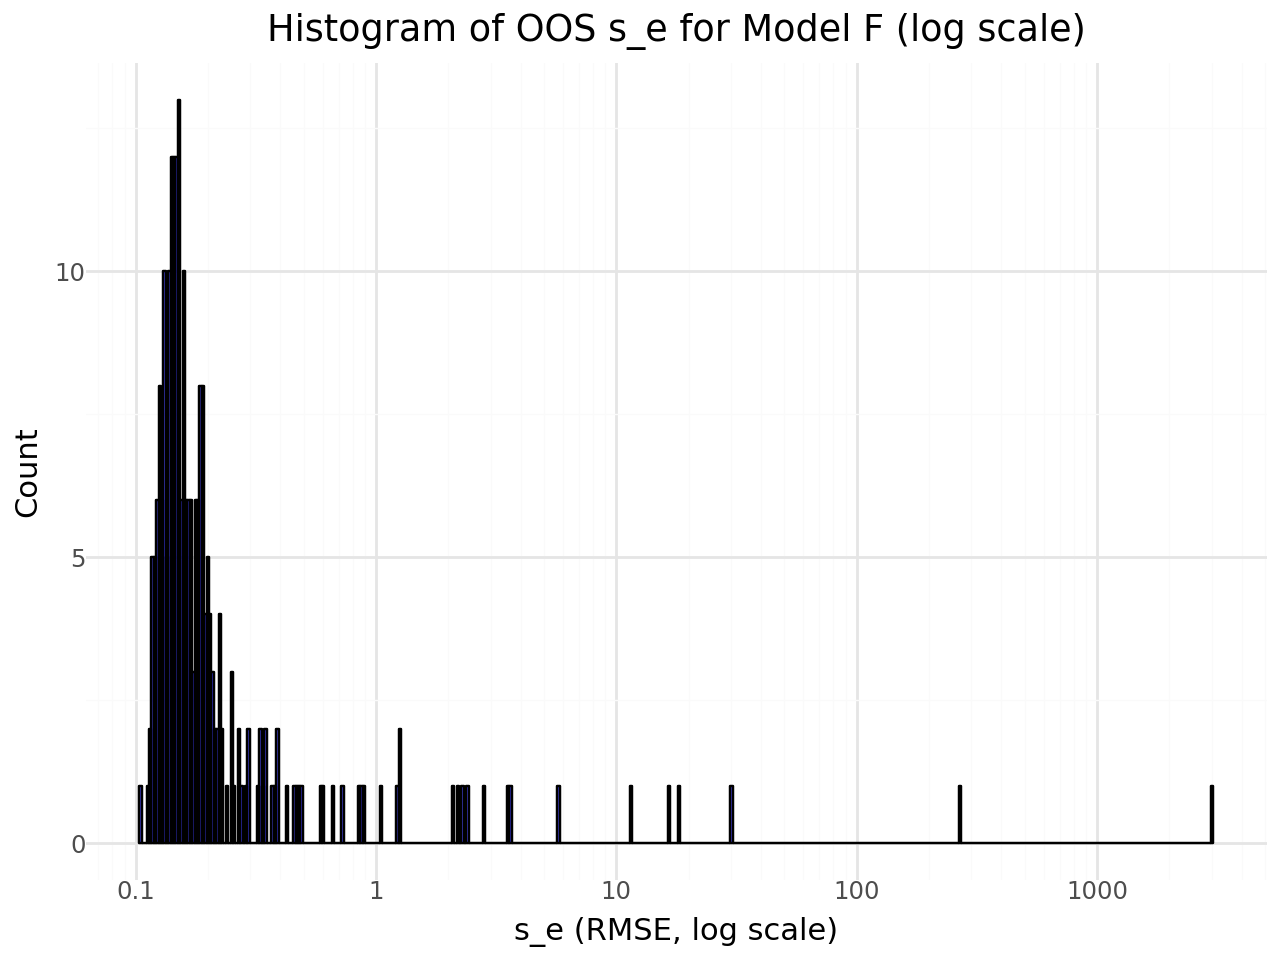

In [113]:
from plotnine import ggplot, aes, geom_histogram, labs, theme_minimal, scale_x_log10

df_plot = pd.DataFrame({'s_e_s_F': s_e_s_F})

p = (ggplot(df_plot, aes(x='s_e_s_F'))
     + geom_histogram(binwidth=0.01, fill="blue", color="black", alpha=0.7)
     + labs(title="Histogram of OOS s_e for Model F (log scale)", 
            x="s_e (RMSE, log scale)", 
            y="Count")
     + scale_x_log10()
     + theme_minimal())
p

#Rcpp and optimizing R

Write a function `dot_product_py` in python that takes in two vectors `v1` and `v2` and returns their dot product.

In [114]:
def dot_product_py(v1, v2):
    if len(v1) != len(v2):
        raise ValueError('Vectors must have same length')
    #compute and return dot product using generator expression
    return sum(a * b for a,b in zip(v1,v2))
    

# Example usage:
v1 = [1,2,3]
v2 = [4,5,6]
print(dot_product_py(v1,v2))  # Output should be 32

32


Write a function `dot_product_cpp` in C++ and make sure it compiles. First uncomment the cell below and install cython

In [115]:
!pip install cython

In [116]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [ ]:
%%cython --cplus
# dot_product_cython.pyx

import numpy as np
cimport numpy as np

def dot_product_cython(np.ndarray[np.double_t, ndim=1] v1, np.ndarray[np.double_t, ndim=1] v2):
    """
    Compute the dot product of two 1D NumPy arrays of type double.
    """
    cdef Py_ssize_t n = v1.shape[0]
    if v2.shape[0] != n:
        raise ValueError("Vectors must have the same length")
    cdef Py_ssize_t i
    cdef double result = 0.0
    for i in range(n):
        result += v1[i] * v2[i]
    return result

In [ ]:
import numpy as np

v1 = np.array([1.0, 2.0, 3.0], dtype=np.float64)
v2 = np.array([4.0, 5.0, 6.0], dtype=np.float64)

result = dot_product_cython(v1, v2)
print("Dot product (Cython):", result)  # Expected output: 32.0

Create two vectors of standard normal realizations with length `n=1e6` and test the different in speed.

In [123]:
import numpy as np
import timeit


Implement the Gram Schmidt routine as a C++ function `gram_schmidt_cython`.

In [148]:
%%cython --cplus
# cython: language_level=3
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def gram_schmidt_cython(np.ndarray[np.double_t, ndim=2] A):
    """
    Perform classical Gram-Schmidt orthonormalization on the columns of matrix A.
    Returns an orthonormal matrix Q (of shape (m, n)) with the same dimensions as A.
    
    Parameters:
      A : np.ndarray[np.double_t, ndim=2]
          Input matrix (m x n), whose columns will be orthonormalized.
    
    Returns:
      Q : np.ndarray[np.double_t, ndim=2]
          Orthonormalized matrix.
    """
    cdef int m = A.shape[0]
    cdef int n = A.shape[1]
    cdef int i, j, k
    cdef double norm_val, dot_val
    cdef np.ndarray[np.double_t, ndim=2] Q = np.empty((m, n), dtype=np.double)
    
    # Copy A into Q
    for j in range(n):
        for i in range(m):
            Q[i, j] = A[i, j]
    
    # Gram-Schmidt process
    for j in range(n):
        # Compute the norm of the j-th column
        norm_val = 0.0
        for i in range(m):
            norm_val += Q[i, j] * Q[i, j]
        norm_val = norm_val ** 0.5
        if norm_val == 0:
            raise ValueError("Zero column encountered in input matrix")
        # Normalize the j-th column
        for i in range(m):
            Q[i, j] /= norm_val
        # Orthogonalize subsequent columns against the j-th column
        for k in range(j + 1, n):
            dot_val = 0.0
            for i in range(m):
                dot_val += Q[i, j] * Q[i, k]
            for i in range(m):
                Q[i, k] -= dot_val * Q[i, j]
                
    return Q



123


Here is the implementation in taken from lab 5:

In [125]:
import numpy as np

def gram_schmidt_R(X):
    """
    Perform classical Gram-Schmidt orthonormalization on the columns of matrix X.
    
    Parameters
    ----------
    X : numpy.ndarray, shape (m, n)
        Input matrix whose columns will be orthonormalized.
    
    Returns
    -------
    Q : numpy.ndarray, shape (m, n)
        Orthonormal matrix whose columns are the orthonormalized version of X's columns.
    """
    m, n = X.shape
    # Create an empty matrix to store the orthogonalized vectors
    V = np.empty((m, n), dtype=X.dtype)
    # Set the first column of V as the first column of X
    V[:, 0] = X[:, 0]
    
    # For each subsequent column j
    for j in range(1, n):
        # Start with the j-th column of X
        V[:, j] = X[:, j]
        # Subtract the projection of X[:, j] on each previously computed v_k
        for k in range(j):
            v_k = V[:, k]
            # Compute the projection coefficient: (v_k^T X[:, j])/(||v_k||^2)
            proj_coeff = np.dot(v_k, X[:, j]) / np.sum(v_k**2)
            # Subtract the projection
            V[:, j] -= proj_coeff * v_k
    
    # Normalize each column of V to obtain Q
    Q = np.empty((m, n), dtype=X.dtype)
    for j in range(n):
        norm = np.sqrt(np.sum(V[:, j]**2))
        Q[:, j] = V[:, j] / norm
    
    return Q


# Example ... Create a random 5x3 matrix
X = np.random.randn(5, 3)
Q = gram_schmidt_R(X)
print("Input matrix X:")
print(X)
print("\nOrthonormal matrix Q:")
print(Q)
# Verify orthonormality: Q^T Q should be close to the identity matrix.
print("\nQ^T Q:")
print(np.dot(Q.T, Q))

Input matrix X:
[[ 4.34197668e-01  8.80535749e-01  3.44937336e-01]
 [ 3.45769929e-01  1.25973654e+00 -1.64662222e-01]
 [ 9.23064571e-01 -8.22000422e-01  1.60708495e+00]
 [ 7.37825392e-01 -4.03759534e-01 -2.11454815e+00]
 [-3.10717131e-04 -1.18180941e+00  2.99634603e-01]]

Orthonormal matrix Q:
[[ 3.32572668e-01  4.40577648e-01  1.82896379e-01]
 [ 2.64841653e-01  6.12281871e-01  1.46507767e-02]
 [ 7.07019107e-01 -3.24327747e-01  5.55752303e-01]
 [ 5.65135599e-01 -1.40687595e-01 -8.09759600e-01]
 [-2.37993045e-04 -5.53191431e-01  4.19885382e-02]]

Q^T Q:
[[ 1.00000000e+00  1.64110346e-17  1.02384524e-16]
 [ 1.64110346e-17  1.00000000e+00 -1.78874157e-17]
 [ 1.02384524e-16 -1.78874157e-17  1.00000000e+00]]


Now let's see how much faster C++ is by running it on the boston housing data design matrix

In [126]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import timeit

# ------------------------------
# Step 1: Load and process the Boston housing data
# ------------------------------
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)

# Combine the two halves: even rows are predictors, odd rows give response and extra columns
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
col_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
             "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]
df = pd.DataFrame(np.hstack([data, target.reshape(-1, 1)]), columns=col_names)
df = df.astype(float)

# ------------------------------
# Step 2: Create design matrix without patsy (using statsmodels)
# ------------------------------
X = df.drop("MEDV", axis=1)
X = sm.add_constant(X)
y = df["MEDV"]

# For benchmarking, convert X to a NumPy array
X_np = np.asarray(X)

# ------------------------------
# Step 4: Assume gram_schmidt_cython is already compiled (fallback to pure Python if not)
# ------------------------------
try:
    gram_schmidt_cython
except NameError:
    print("Warning: gram_schmidt_cython is not defined; using pure Python version instead.")
    gram_schmidt_cython = gram_schmidt_R

# ------------------------------
# Step 5: Benchmark both implementations using timeit (10 runs each)
# ------------------------------
py_time = timeit.timeit(lambda: gram_schmidt_R(X_np), number=10)
cy_time = timeit.timeit(lambda: gram_schmidt_cython(X_np), number=10)

print("Pure Python Gram-Schmidt time over 10 runs:", py_time)
print("Cython Gram-Schmidt time over 10 runs:", cy_time)

Pure Python Gram-Schmidt time over 10 runs: 0.013109300009091385
Cython Gram-Schmidt time over 10 runs: 0.009378500006278045


Extra Credit (+5): Create a variable `n` to be 10 and a vaiable `Nvec` to be 100 initially. Create a random vector via `np.random.randn` `Nvec` times and load it into a `Nvec` x `n` dimensional matrix.

In [130]:
import numpy as np

# Extra Credit: Step 1 - Create random vectors
n = 10  # Number of dimensions
Nvec = 100  # Number of vectors

# Generate a random matrix with Nvec rows and n columns
X = np.random.randn(Nvec, n)

print("Random Matrix X (100x10):")
print(X)

Random Matrix X (100x10):
[[-3.50833911e-01 -1.00103512e+00  4.42974744e-01 -4.44448217e-01
   1.75620580e+00  2.14638455e+00  2.14042078e+00 -6.35496565e-01
  -5.07267381e-01 -1.21091889e+00]
 [ 6.48398075e-01 -8.54835666e-01 -6.03773367e-01 -8.87569617e-01
  -5.56833440e-01  1.65372589e+00 -2.46666707e+00  5.25892821e-01
  -8.06398646e-01  2.34421272e+00]
 [ 8.27985527e-01 -1.01875100e+00 -6.10749324e-01 -5.69930871e-01
   1.15065800e+00  1.69446740e+00  1.53617510e-01 -1.43221076e-01
   1.04374501e+00  2.73612593e-02]
 [ 4.67955916e-01  2.21304047e-01 -7.88258817e-01  1.36326305e+00
  -5.91859475e-01  1.93779925e+00  1.18018384e+00  1.93700851e-01
  -1.24378568e+00  1.67582710e+00]
 [ 3.15378142e-01  8.93568945e-01  1.47693538e+00 -1.12000272e+00
   3.63630444e-01 -3.76926156e-01  3.19488753e-01  4.57126775e-01
  -1.66357389e+00 -2.28079476e-01]
 [ 8.96491031e-02 -1.25232507e+00 -7.35347543e-01  1.24634866e-01
   6.86242624e-01 -1.46703944e-01 -6.98785554e-01 -1.00417124e+00
  -3.57

Extra Credit (+5): Write a function `all_angles` that measures the angle between each of the pairs of vectors. You should measure the vector on a scale of 0 to 180 degrees with negative angles coerced to be positive. Then plot the density of these angles.

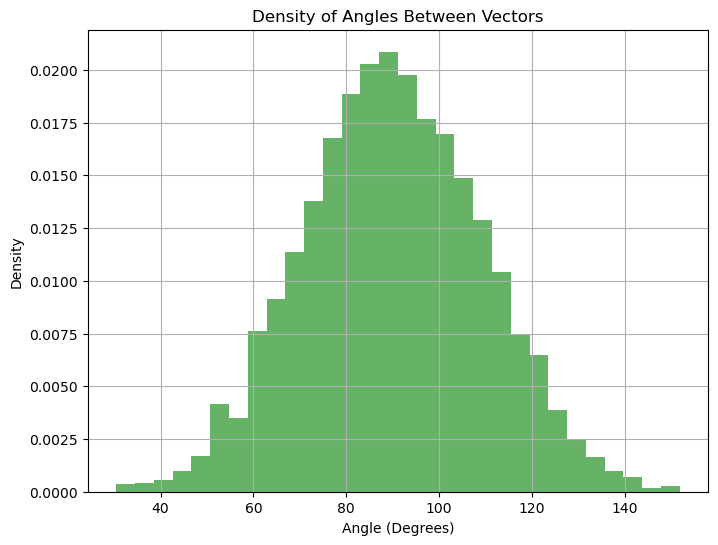

In [129]:
import matplotlib.pyplot as plt

def all_angles(X):
    """
    Measure the angle between each pair of vectors in X and return the angles in degrees.
    
    Parameters
    ----------
    X : numpy.ndarray, shape (Nvec, n)
        Input matrix whose rows are vectors for which we calculate angles.
    
    Returns
    -------
    angles : numpy.ndarray, shape (Nvec*(Nvec-1)//2,)
        Array containing angles between all pairs of vectors in X.
    """
    Nvec, n = X.shape
    angles = []
    
    # Loop over all pairs of vectors
    for i in range(Nvec):
        for j in range(i + 1, Nvec):
            u = X[i]
            v = X[j]
            # Compute the dot product and norms
            dot_product = np.dot(u, v)
            norm_u = np.linalg.norm(u)
            norm_v = np.linalg.norm(v)
            # Compute the cosine of the angle
            cos_theta = dot_product / (norm_u * norm_v)
            # Compute the angle in radians and convert to degrees
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0)) * (180.0 / np.pi)
            # Append the angle
            angles.append(angle)
    
    return np.array(angles)

# Step 2 - Calculate the angles between all pairs of vectors
angles = all_angles(X)

# Plot the density of angles
plt.figure(figsize=(8, 6))
plt.hist(angles, bins=30, density=True, alpha=0.6, color='g')
plt.title('Density of Angles Between Vectors')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Density')
plt.grid(True)
plt.show()


Write an Rcpp function `all_angles_cpp` that does the same thing. Use an IDE if you want, but write it below in-line.

In [146]:
%%cython --cplus
# cython: language_level=3
import numpy as np
cimport numpy as np
from libc.math cimport acos, sqrt, M_PI

def all_angles_cy(np.ndarray[np.double_t, ndim=2] X):
    """
    Compute the angle (in degrees) between each pair of vectors (rows of X)
    using the classical dot product formula. Returns an n x n matrix of angles.
    
    Parameters
    ----------
    X : np.ndarray[np.double_t, ndim=2]
         Input matrix with shape (n, m), where each row is a vector.
    
    Returns
    -------
    angle_matrix : np.ndarray[np.double_t, ndim=2]
         Matrix of angles (in degrees) between the vectors.
    """
    cdef int n = X.shape[0]
    cdef int m = X.shape[1]
    cdef int i, j, k
    cdef double dot_prod, norm_i, norm_j, cos_val, angle_rad, angle_deg
    cdef np.ndarray[np.double_t, ndim=2] angle_matrix = np.empty((n, n), dtype=np.double)
    
    for i in range(n):
        for j in range(i, n):
            dot_prod = 0.0
            norm_i = 0.0
            norm_j = 0.0
            for k in range(m):
                dot_prod += X[i, k] * X[j, k]
                norm_i += X[i, k] * X[i, k]
                norm_j += X[j, k] * X[j, k]
            norm_i = sqrt(norm_i)
            norm_j = sqrt(norm_j)
            cos_val = dot_prod / (norm_i * norm_j)
            if (cos_val > 1.0):
                cos_val = 1.0
            elif (cos_val < -1.0):
                cos_val = -1.0
            angle_rad = acos(cos_val)
            angle_deg = angle_rad * 180.0 / M_PI
            angle_matrix[i, j] = angle_deg
            angle_matrix[j, i] = angle_deg
    return angle_matrix


DistutilsPlatformError: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/

In [ ]:
import numpy as np

# Create a small example matrix where each row is a vector.
X_example = np.array([[1.0, 0.0],
                      [0.0, 1.0],
                      [1.0, 1.0]])
print(all_angles_cy(X_example))

Extra Credit (+5): Test the time difference between these functions for `n = 1000` and `Nvec = 100, 500, 1000, 5000` using the package `microbenchmark`.  Store the results in a matrix with rows representing `Nvec` and two columns for base R and Rcpp.